# Bayesian Assignment of State T61 Without D-SubUnit

In [1]:
import os
import numpy as np 
import pandas as pd
import arviz as az
import warnings
import sys
sys.path.append("..")
sys.path.append("../../spc_utils")
import spc_os
import pickle
import cellbell
import seaborn as sns
import cellbell
import matplotlib.pyplot as plt
from scipy.stats import halfcauchy, skewnorm, norm
from src.visualization.handle_data import combine_posterior_variables
from src.features.build_features import get_significant
#cpu or cuda
os.environ['THEANO_FLAGS'] = 'mode=FAST_RUN,device=cpu,floatX=float64'
import pymc3 as pm
RANDOM_SEED = 281090
warnings.filterwarnings("ignore")

In [2]:
raw_data_dir = '../data/raw/'
interim_data_dir = '../data/interim/'
processed_data_dir = '../data/processed/'
external_data_dir = '../data/external/'
models_dir = '../models/bayesian/'
reports_dir = '../reports/'

In [3]:
%mkdir ../models/bayesian

mkdir: cannot create directory ‘../models/bayesian’: File exists


In [4]:
with open('../data/aa_resid_dic.pkl', 'rb') as my_file:
    aa_dic = pickle.load(my_file)

## Set-up parameters

In [5]:
method = 'sparta_plus' # shiftx2 sparta_plus or ppm
nucleus = 'N' #  N CA CB C
data_size = 2000 # 70000 max data_size
model_name = 'skew_model_T61'
infer = False
critique = True
do_ppc = True

## Load and prepare data

Mask according to nuclei present in all 3 experimental states. Sample part of the data and select the nucleus.

In [6]:
df_diff = pd.read_pickle(processed_data_dir + 'diff_CS.pkl')

Only study T61

In [7]:
mask = df_diff.dropna(axis=1).loc[:,[61]].columns

In [8]:
df_diff = df_diff.loc[:, mask].xs(nucleus, level='nuclei', axis=1).dropna(axis=1)

In [9]:
df_exp_o = pd.read_pickle(processed_data_dir + 'open_CS.pkl')

In [10]:
df_exp_o = df_exp_o.loc[:, mask].xs(nucleus, level='nuclei', axis=1).dropna(axis=1)

In [11]:
df_3fb5 = pd.read_pickle(processed_data_dir +
                         f'3FB5_lb/CS_{method}_3FB5_lb.pkl')

Drop segname D of T61

In [12]:
select_ABC = [i for i in range(df_3fb5.shape[0]) if  (i + 1) % 4 != 0 ]

In [13]:
df_3fb5 = df_3fb5.reindex(columns=mask).loc[select_ABC, :].sample(data_size,
                                      random_state=RANDOM_SEED)
df_3fb5 = df_3fb5.xs(nucleus, level='nuclei', axis=1).dropna(axis=1)

In [14]:
df_5vk6 = pd.read_pickle(processed_data_dir +
                         f'5VK6_lb/CS_{method}_5VK6_lb.pkl')

In [15]:
df_5vk6 = df_5vk6.reindex(columns=mask).sample(data_size,
                                      random_state=RANDOM_SEED)
df_5vk6 = df_5vk6.xs(nucleus, level='nuclei', axis=1).dropna(axis=1)

In [16]:
df_5vkh = pd.read_pickle(processed_data_dir +
                         f'5VKH_lb/CS_{method}_5VKH_lb.pkl')

In [17]:
df_5vkh = df_5vkh.reindex(columns=mask).sample(data_size,
                                      random_state=RANDOM_SEED)
df_5vkh = df_5vkh.xs(nucleus, level='nuclei', axis=1).dropna(axis=1)

In [18]:
coords = {
    'resid': [aa_dic[res] + str(res) for res in df_3fb5.columns],
    'step': df_3fb5.index
}

In [19]:
mask = df_3fb5.columns

In [20]:
df_diff = df_diff[mask]

In [21]:
df_exp_o = df_exp_o[mask]

## Study Data

Some notes on CA:
+ Fast exchange: 33,38, 71, 85, 107
+ One SU different: 61
+ Assymettrical subunits: 44, 51
+ Change during trajectory: 69
+ Homogeneous: Rest

Some notes on N:
+

### Histograms

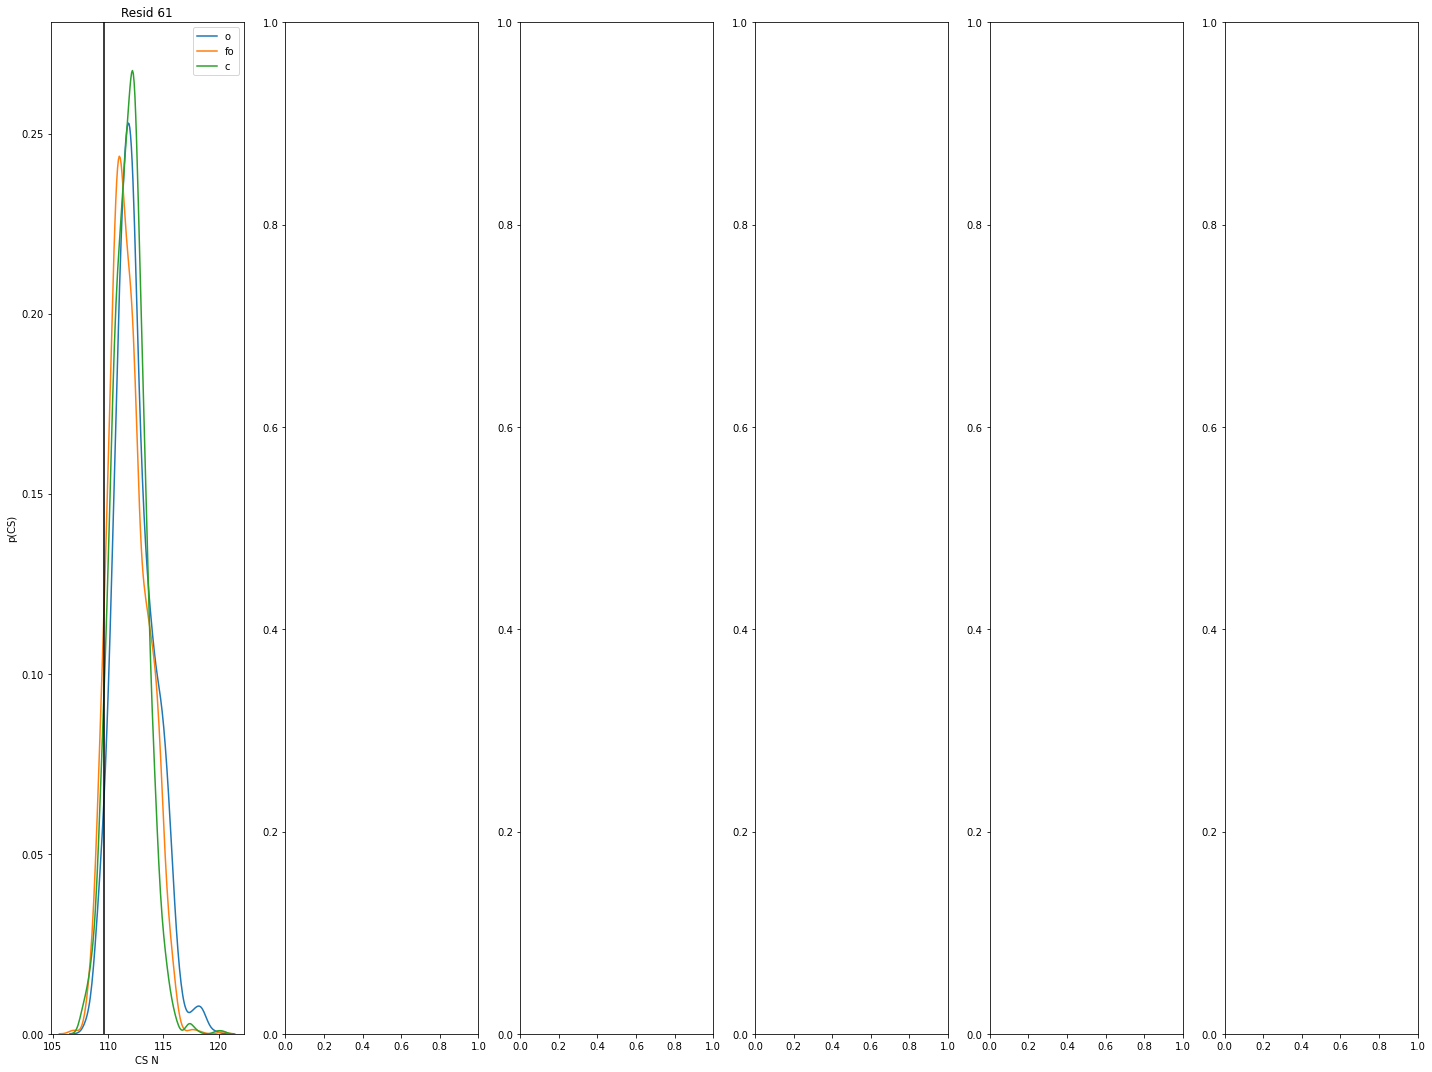

In [461]:
fig, ax = plt.subplots(df_3fb5.shape[1] // 6 + 1, 6, figsize=(20, 15))
ax = ax.flatten()
for i, resid in enumerate(df_3fb5):
    sns.kdeplot(df_3fb5[resid], ax=ax[i], label='o')
    sns.kdeplot(df_5vk6[resid], ax=ax[i], label='fo')
    sns.kdeplot(df_5vkh[resid], ax=ax[i], label='c')
    ax[i].set_title(f'Resid {resid}')
    ax[i].set_xlabel(f'CS {nucleus}')
    ax[i].set_ylabel('p(CS)')
    ax[i].axvline(x=df_exp_o[resid][0], c="black")
    ax[i].legend()
fig.tight_layout()
fig.savefig(reports_dir + f'hist_{method}_{nucleus}.png')

### Time series

#### Closed

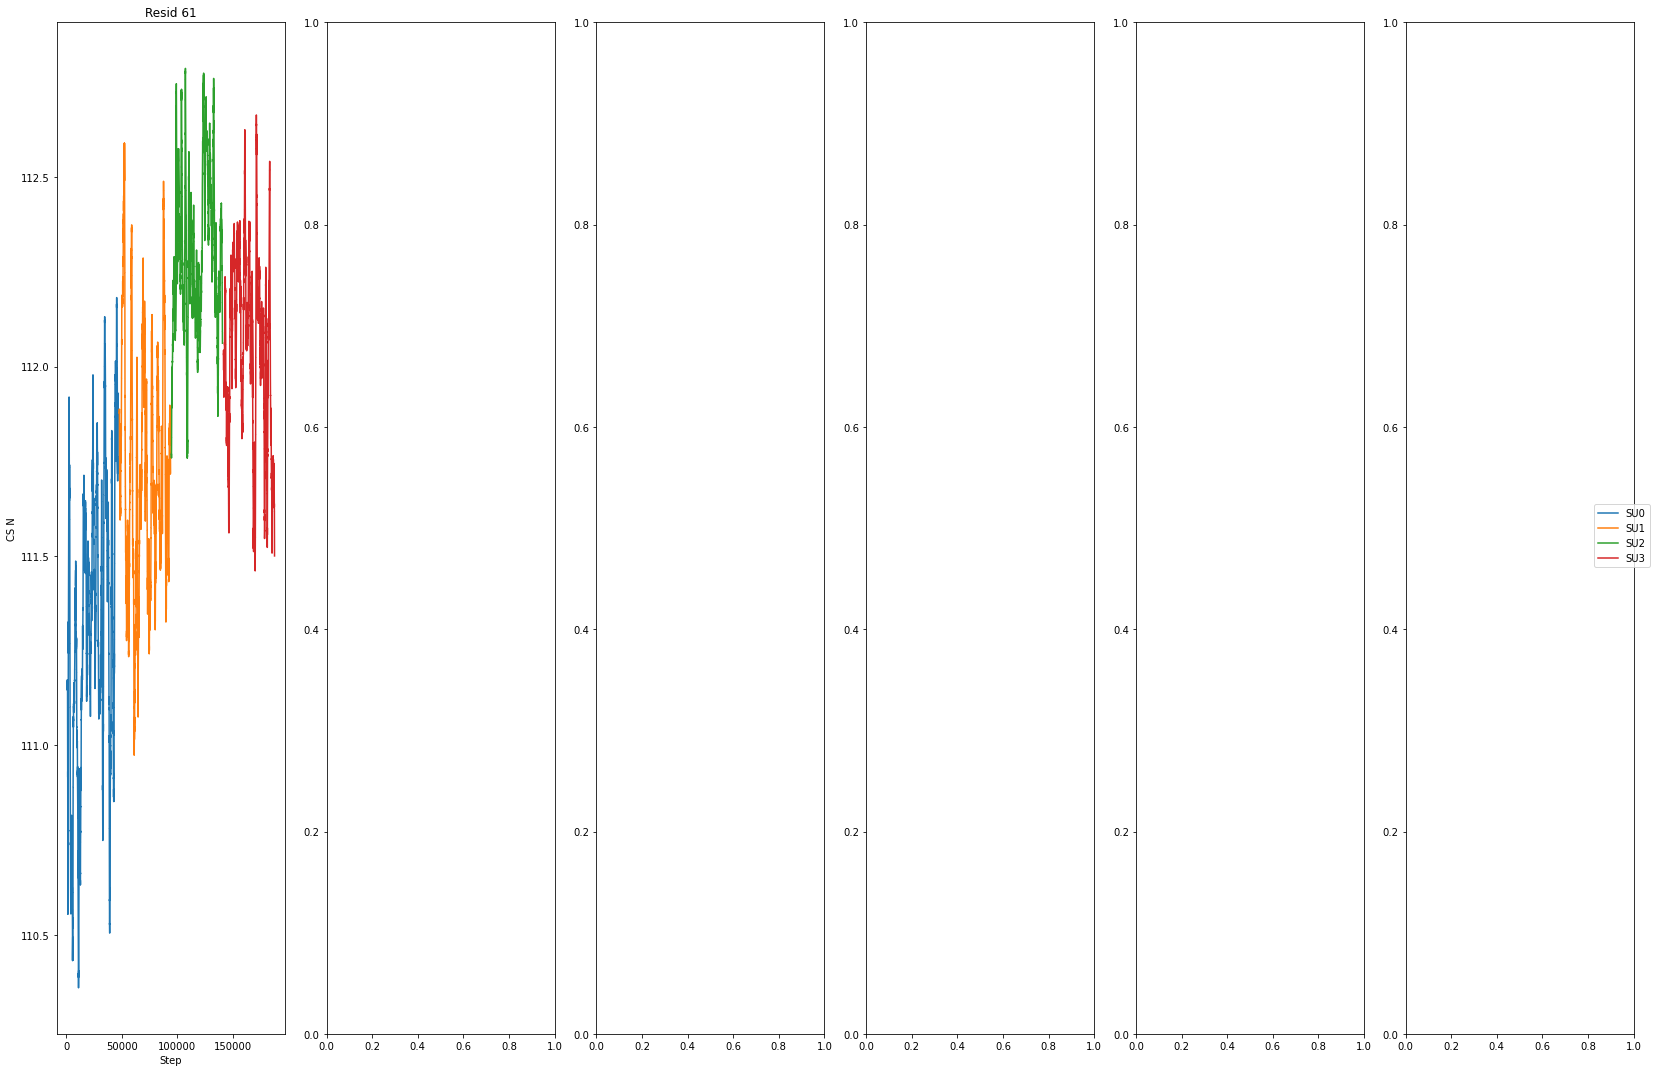

In [462]:
state = '5VKH_lb'
df = pd.read_pickle(f'{processed_data_dir}{state}/CS_{method}_{state}.pkl')
df = df.xs(nucleus, level='nuclei', axis=1).reindex(columns=mask)
n_roll = 1000
fig, ax = plt.subplots(df.shape[1] // 6 + 1, 6, figsize=(23, 15))
ax = ax.flatten()
for i, resid in enumerate(df):
    for j, split in enumerate(np.split(df[resid], 4)):
        y = split.rolling(n_roll).median()[n_roll:]
        ax[i].plot(y, label=f'SU{j}')
    ax[i].set_title(f'Resid {resid}')
    ax[i].set_ylabel(f'CS {nucleus}')
    ax[i].set_xlabel('Step')
handles, labels = ax[i].get_legend_handles_labels()
fig.legend(handles, labels, loc='center right')
fig.tight_layout()
fig.savefig(reports_dir + f'time_series_{method}_{nucleus}_{state}.png')
del df

#### Open

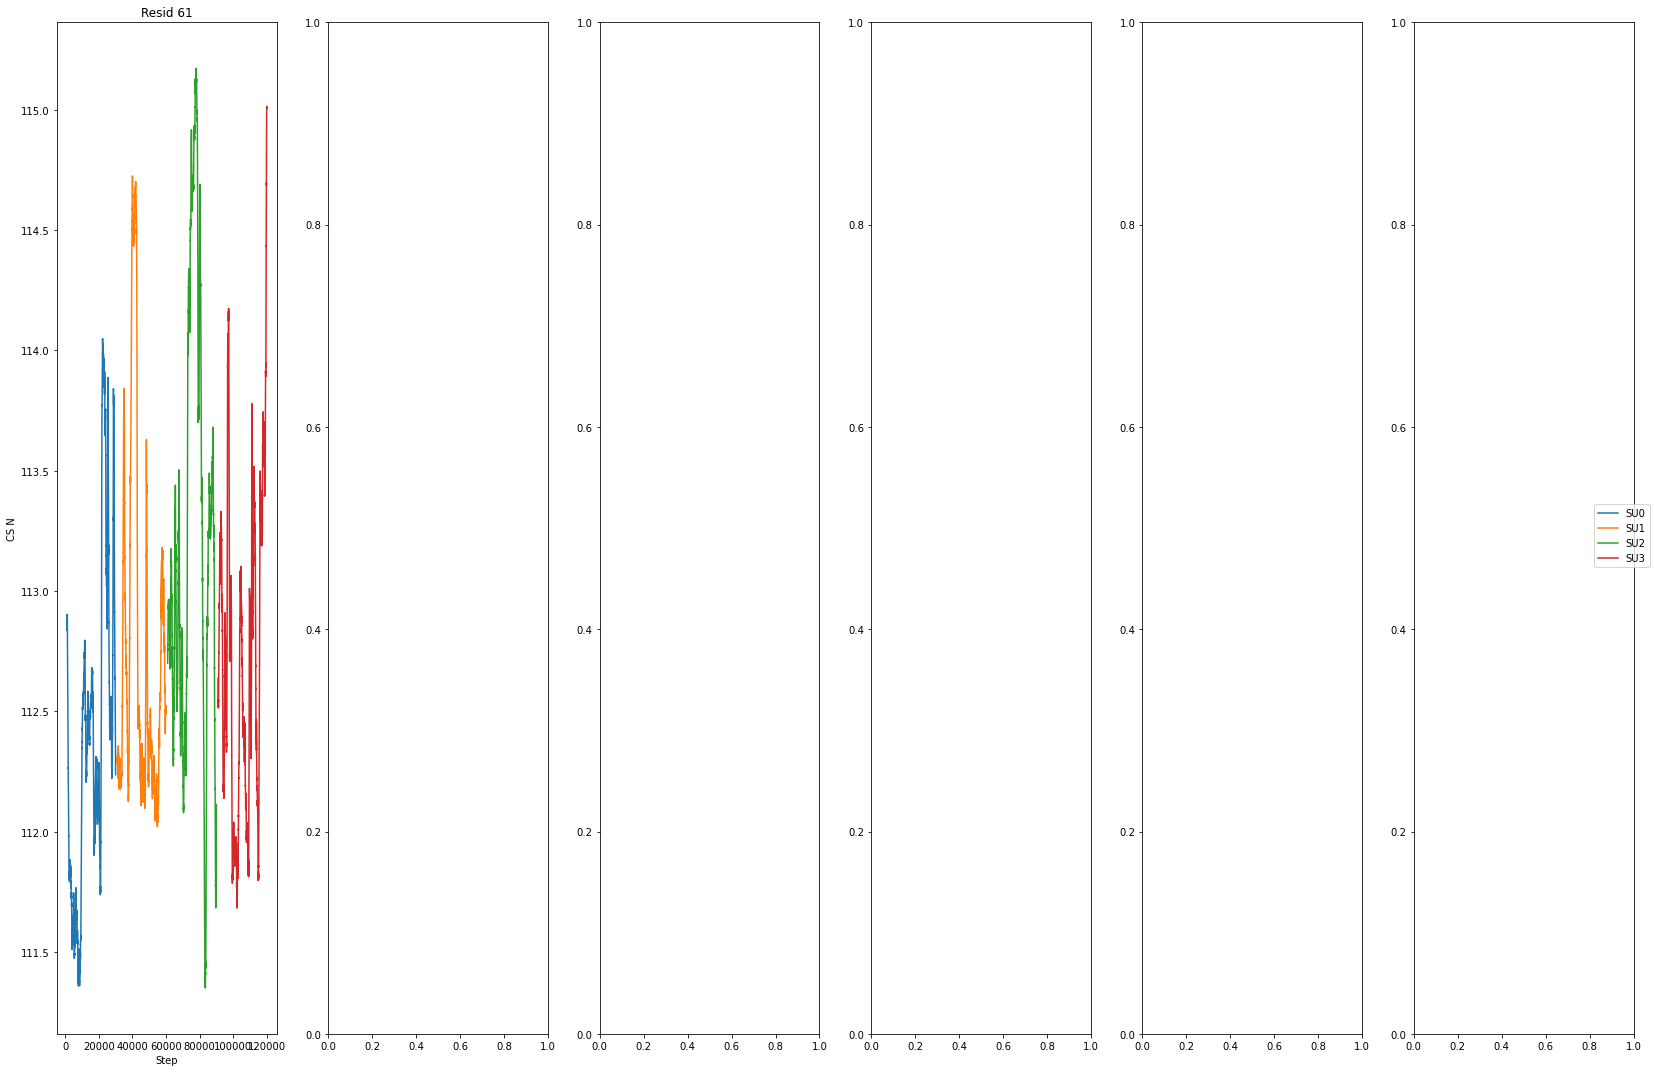

In [463]:
state = '3FB5_lb'
df = pd.read_pickle(f'{processed_data_dir}{state}/CS_{method}_{state}.pkl')
df = df.xs(nucleus, level='nuclei', axis=1).reindex(columns=mask)
n_roll = 1000
fig, ax = plt.subplots(df.shape[1] // 6 + 1, 6, figsize=(23, 15))
ax = ax.flatten()
for i, resid in enumerate(df):
    for j, split in enumerate(np.split(df[resid], 4)):
        y = split.rolling(n_roll).median()[n_roll:]
        ax[i].plot(y, label=f'SU{j}')
    ax[i].set_title(f'Resid {resid}')
    ax[i].set_ylabel(f'CS {nucleus}')
    ax[i].set_xlabel('Step')
handles, labels = ax[i].get_legend_handles_labels()
fig.legend(handles, labels, loc='center right')
fig.tight_layout()
fig.savefig(reports_dir + f'time_series_{method}_{nucleus}_{state}.png')
del df

#### Fully Open

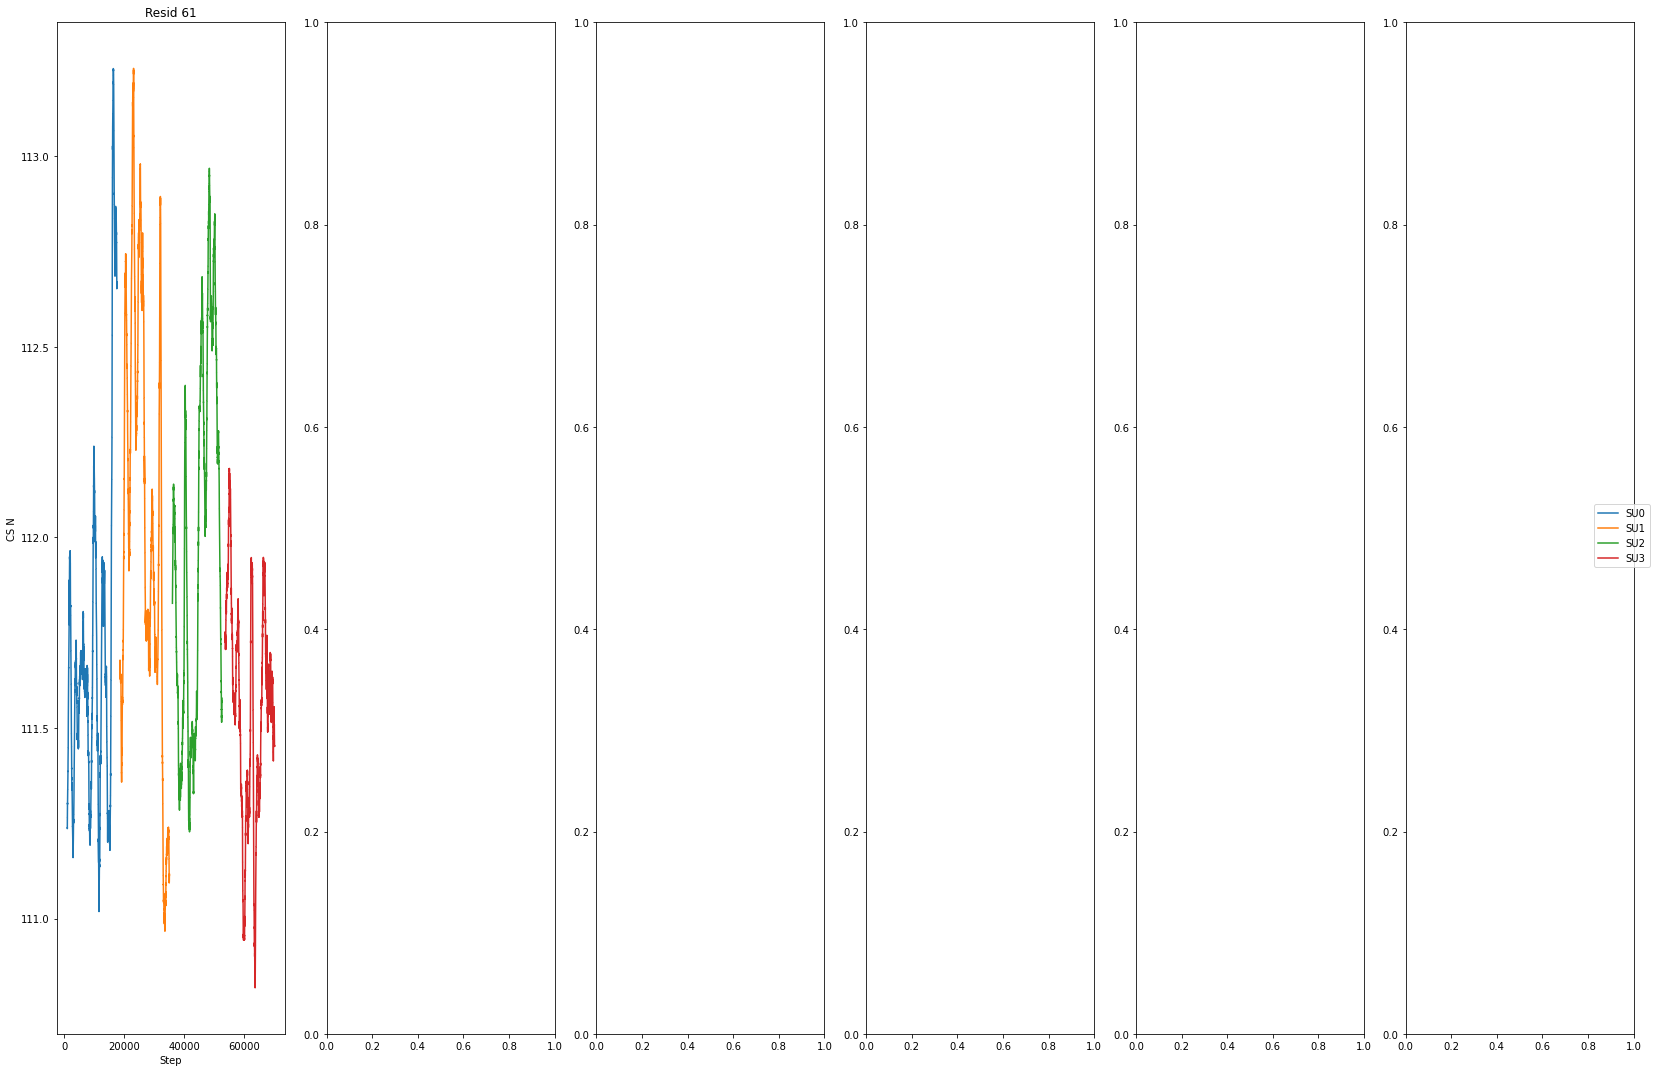

In [464]:
state = '5VK6_lb'
df = pd.read_pickle(f'{processed_data_dir}{state}/CS_{method}_{state}.pkl')
df = df.xs(nucleus, level='nuclei', axis=1).reindex(columns=mask)
n_roll = 1000
fig, ax = plt.subplots(df.shape[1] // 6 + 1, 6, figsize=(23, 15))
ax = ax.flatten()
for i, resid in enumerate(df):
    for j, split in enumerate(np.split(df[resid], 4)):
        y = split.rolling(n_roll).median()[n_roll:]
        ax[i].plot(y, label=f'SU{j}')
    ax[i].set_title(f'Resid {resid}')
    ax[i].set_ylabel(f'CS {nucleus}')
    ax[i].set_xlabel('Step')
handles, labels = ax[i].get_legend_handles_labels()
fig.legend(handles, labels, loc='center right')
fig.tight_layout()
fig.savefig(reports_dir + f'time_series_{method}_{nucleus}_{state}.png')
del df

## Model Data

In [24]:
def skew_mean(mu, sig, alpha):
    mean = mu + sig * np.sqrt(2. / np.pi) * alpha / np.sqrt(1 + alpha * alpha)
    return mean

In [25]:
def skew_std(sig, alpha):
    std = np.sqrt(sig * sig * (1 - 2 * alpha * alpha / (alpha * alpha + 1) / np.pi))
    return std

In [26]:
if model_name == 'skew_model_T61':
    beta_prior = 10
    alpha_prior = 10
    sd_prior = 10
    diff_vector = df_diff.to_numpy().reshape([df_diff.shape[1],])
    open_vector = df_exp_o.to_numpy().reshape([df_diff.shape[1],])
    with pm.Model(coords=coords) as my_model:
        mu_o = pm.Normal('mu_o', mu=df_3fb5.mean(), sd=sd_prior, dims='resid')
        sd_o = pm.HalfCauchy('sd_o', beta=beta_prior, dims='resid')
        alpha_o = pm.Normal('alpha_o', mu=0, sd=alpha_prior, dims='resid')
        mu_fo = pm.Normal('mu_fo', mu=df_5vk6.mean(), sd=sd_prior, dims='resid')
        sd_fo = pm.HalfCauchy('sd_fo', beta=beta_prior, dims='resid')
        alpha_fo = pm.Normal('alpha_fo', mu=0, sd=alpha_prior, dims='resid')
        mu_c = pm.Normal('mu_c', mu=df_5vkh.mean(), sd=sd_prior, dims='resid')
        sd_c = pm.HalfCauchy('sd_c', beta=beta_prior, dims='resid')
        alpha_c = pm.Normal('alpha_c', mu=0, sd=alpha_prior, dims='resid')

        # Define the likelihood.
        like_o = pm.SkewNormal('like_o',
                           mu=mu_o,
                           sd=sd_o,
                           alpha=alpha_o,
                           observed=df_3fb5,
                           dims=('step', 'resid')
                           )
        like_c = pm.SkewNormal('like_c',
                           mu=mu_c,
                           sd=sd_c,
                           alpha=alpha_c,
                           observed=df_5vkh,
                           dims=('step', 'resid')
                           )
        like_fo = pm.SkewNormal('like_fo',
                           mu=mu_fo,
                           sd=sd_fo,
                           alpha=alpha_fo,
                           observed=df_5vk6,
                           dims=('step', 'resid')
                           )
        mean_o = pm.Deterministic('mean_o', skew_mean(mu_o, sd_o, alpha_o), dims='resid')
        mean_fo = pm.Deterministic('mean_fo', skew_mean(mu_fo, sd_fo, alpha_fo), dims='resid')
        mean_c = pm.Deterministic('mean_c', skew_mean(mu_c, sd_c, alpha_c), dims='resid')
        std_o = skew_std(sd_o, alpha_o)
        std_fo = skew_std(sd_fo, alpha_fo)
        std_c = skew_std(sd_c, alpha_c)
        diff_means = pm.Deterministic('diff_means', mean_o - mean_fo, dims='resid')
        delta_o = pm.Deterministic('delta_o', mean_o - mean_c, dims='resid')
        delta_fo = pm.Deterministic('delta_fo', mean_fo - mean_c, dims='resid')
        mean_o_c = pm.Deterministic('mean_o_c', mean_o - mean_c - diff_vector, dims='resid')
        mean_fo_c = pm.Deterministic('mean_fo_c', mean_fo - mean_c - diff_vector, dims='resid')
        mean_o_c_abs = pm.Deterministic('mean_o_c_abs', np.abs(mean_o - mean_c - diff_vector), dims='resid')
        mean_fo_c_abs = pm.Deterministic('mean_fo_c_abs', np.abs(mean_fo - mean_c - diff_vector), dims='resid')
        mean_o_o = pm.Deterministic('mean_o_o', mean_o - open_vector, dims='resid')
        mean_fo_o = pm.Deterministic('mean_fo_o', mean_fo - open_vector, dims='resid')
        mean_o_o_abs = pm.Deterministic('mean_o_o_abs', np.abs(mean_o - open_vector), dims='resid')
        mean_fo_o_abs = pm.Deterministic('mean_fo_o_abs', np.abs(mean_fo - open_vector), dims='resid') 
        pooled_sd = np.sqrt(np.power(std_o, 2) + np.power(std_fo, 2) / (2))
        effect_size = pm.Deterministic('effect_size',
                                       diff_means / pooled_sd, dims='resid')
    model_path = models_dir + f"{model_name}_{method}_{nucleus}.nc"

In [27]:
%%time
%%ding
if infer:
    with my_model:
        my_model_trace = pm.sample(2000, tune=1000, random_seed=RANDOM_SEED, return_inferencedata=False)
        ppc = pm.sample_posterior_predictive(my_model_trace, var_names=["like_fo","like_o","like_c"], random_seed=RANDOM_SEED)
    my_model_trace = az.from_pymc3(trace=my_model_trace, model=my_model, posterior_predictive=ppc)
    print('Done infering.')
    spc_os.remove(model_path)
    my_model_trace.to_netcdf(model_path)
    print('Done saving.')
    del ppc

CPU times: user 173 ms, sys: 0 ns, total: 173 ms
Wall time: 1.62 s


## Critize model 

In [28]:
my_model_trace = az.from_netcdf(model_path)

In [29]:
spc_os.mkdir(reports_dir + f'critique/{model_name}_{method}_{nucleus}')

In [30]:
my_model_trace.posterior_predictive

<xarray.Dataset>
Dimensions:  (chain: 4, draw: 2000, resid: 1, step: 2000)
Coordinates:
  * chain    (chain) int64 0 1 2 3
  * draw     (draw) int64 0 1 2 3 4 5 6 7 ... 1993 1994 1995 1996 1997 1998 1999
  * step     (step) int64 25608 98608 7526 72518 ... 17945 118065 91740 52216
  * resid    (resid) object 'T61'
Data variables:
    like_fo  (chain, draw, step, resid) float64 ...
    like_o   (chain, draw, step, resid) float64 ...
    like_c   (chain, draw, step, resid) float64 ...
Attributes:
    created_at:                 2020-11-26T20:29:31.762698
    arviz_version:              0.10.0
    inference_library:          pymc3
    inference_library_version:  3.9.3

### Point Summaries

Check that r_hat is approx 1 and that ess_mean is near to the number of steps.

In [ ]:
if critique:
    df_summary = az.summary(my_model_trace)
    with pd.option_context('display.max_rows', None):
        print(df_summary)

### Plot Traces (Posteriors)

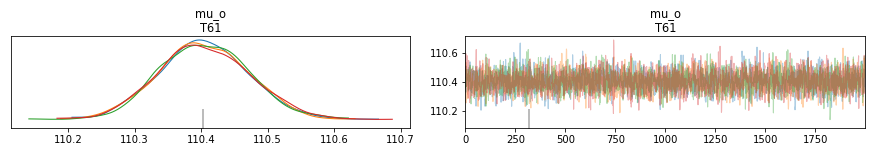

In [472]:
if critique:
    magnitude = 'mu_o'
    with az.rc_context(rc={'plot.max_subplots': df_3fb5.shape[1] * 2}):
        az.plot_trace(my_model_trace, var_names=[magnitude])
    plt.savefig(reports_dir + f'critique/{model_name}_{method}_{nucleus}/trace_{magnitude}.png')

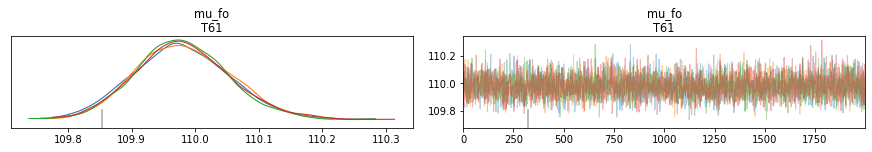

In [473]:
if critique:
    magnitude = 'mu_fo'
    with az.rc_context(rc={'plot.max_subplots': df_3fb5.shape[1] * 2}):
        az.plot_trace(my_model_trace, var_names=[magnitude])
    plt.savefig(reports_dir + f'critique/{model_name}_{method}_{nucleus}/trace_{magnitude}.png')

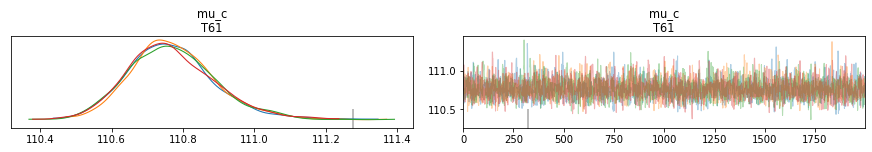

In [474]:
if critique:
    magnitude = 'mu_c'
    with az.rc_context(rc={'plot.max_subplots': df_3fb5.shape[1] * 2}):
        az.plot_trace(my_model_trace, var_names=[magnitude])
    plt.savefig(reports_dir + f'critique/{model_name}_{method}_{nucleus}/trace_{magnitude}.png')

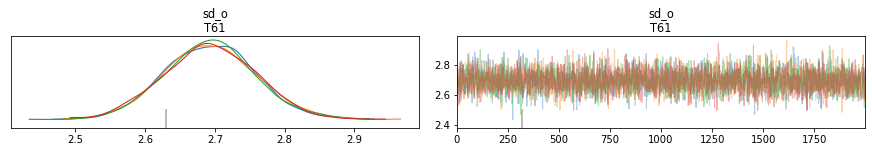

In [475]:
if critique:
    magnitude = 'sd_o'
    with az.rc_context(rc={'plot.max_subplots': df_3fb5.shape[1] * 2}):
        az.plot_trace(my_model_trace, var_names=[magnitude])
    plt.savefig(reports_dir + f'critique/{model_name}_{method}_{nucleus}/trace_{magnitude}.png')

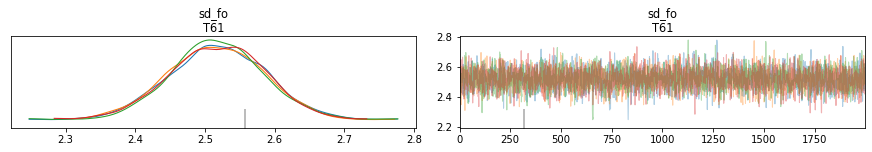

In [476]:
if critique:
    magnitude = 'sd_fo'
    with az.rc_context(rc={'plot.max_subplots': df_3fb5.shape[1] * 2}):
        az.plot_trace(my_model_trace, var_names=[magnitude])
    plt.savefig(reports_dir + f'critique/{model_name}_{method}_{nucleus}/trace_{magnitude}.png')

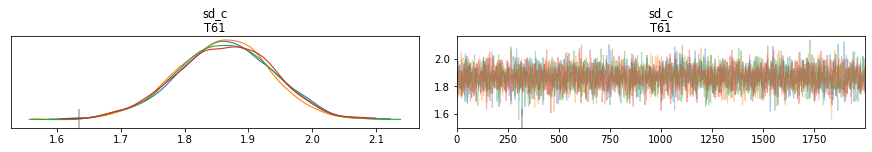

In [477]:
if critique:
    magnitude = 'sd_c'
    with az.rc_context(rc={'plot.max_subplots': df_3fb5.shape[1] * 2}):
        az.plot_trace(my_model_trace, var_names=[magnitude])
    plt.savefig(reports_dir + f'critique/{model_name}_{method}_{nucleus}/trace_{magnitude}.png')

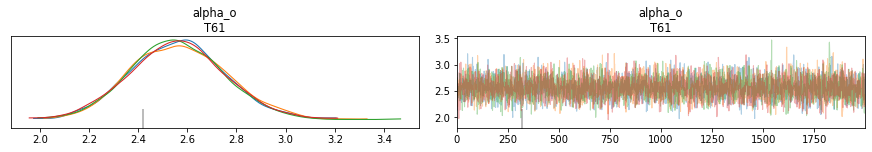

In [478]:
if critique:
    magnitude = 'alpha_o'
    with az.rc_context(rc={'plot.max_subplots': df_3fb5.shape[1] * 2}):
        az.plot_trace(my_model_trace, var_names=[magnitude])
    plt.savefig(reports_dir + f'critique/{model_name}_{method}_{nucleus}/trace_{magnitude}.png')

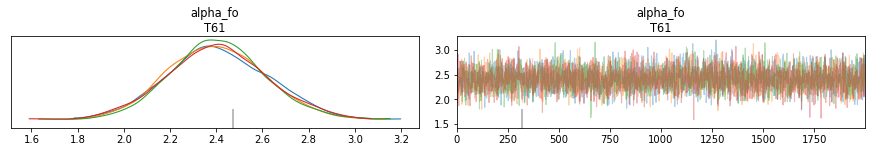

In [479]:
if critique:
    magnitude = 'alpha_fo'
    with az.rc_context(rc={'plot.max_subplots': df_3fb5.shape[1] * 2}):
        az.plot_trace(my_model_trace, var_names=[magnitude])
    plt.savefig(reports_dir + f'critique/{model_name}_{method}_{nucleus}/trace_{magnitude}.png')

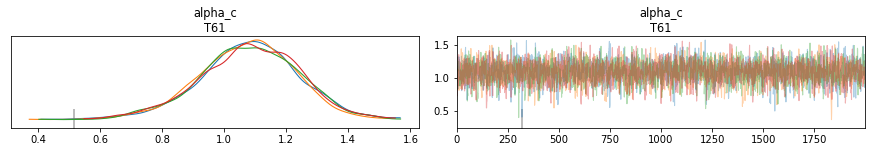

In [480]:
if critique:
    magnitude = 'alpha_c'
    with az.rc_context(rc={'plot.max_subplots': df_3fb5.shape[1] * 2}):
        az.plot_trace(my_model_trace, var_names=[magnitude])
    plt.savefig(reports_dir + f'critique/{model_name}_{method}_{nucleus}/trace_{magnitude}.png')

### Autocorrelations

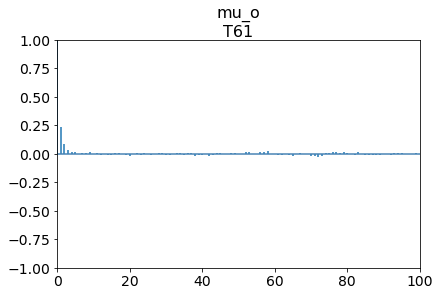

In [481]:
if critique:
    magnitude = 'mu_o'
    with az.rc_context(rc={'plot.max_subplots': None}):
        az.plot_autocorr(my_model_trace, combined=True, var_names=[magnitude])
    plt.savefig(
        f'{reports_dir}critique/{model_name}_{method}_{nucleus}/autocorr_{magnitude}.png')

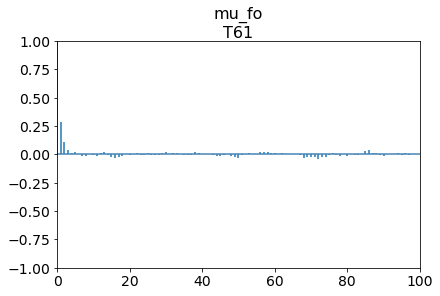

In [482]:
if critique:
    magnitude = 'mu_fo'
    with az.rc_context(rc={'plot.max_subplots': None}):
        az.plot_autocorr(my_model_trace, combined=True, var_names=[magnitude])
    plt.savefig(
        f'{reports_dir}critique/{model_name}_{method}_{nucleus}/autocorr_{magnitude}.png')

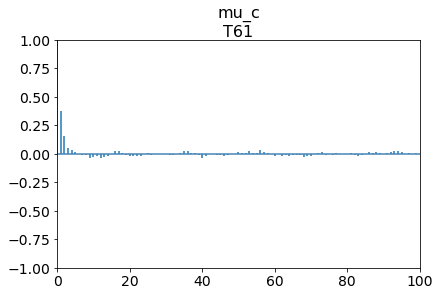

In [483]:
if critique:
    magnitude = 'mu_c'
    with az.rc_context(rc={'plot.max_subplots': None}):
        az.plot_autocorr(my_model_trace, combined=True, var_names=[magnitude])
    plt.savefig(
        f'{reports_dir}critique/{model_name}_{method}_{nucleus}/autocorr_{magnitude}.png')

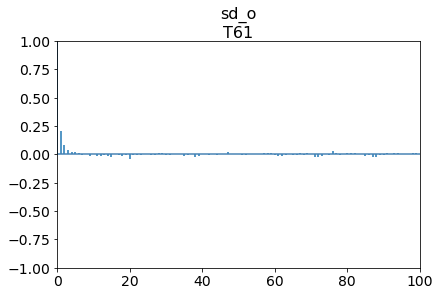

In [484]:
if critique:
    magnitude = 'sd_o'
    with az.rc_context(rc={'plot.max_subplots': None}):
        az.plot_autocorr(my_model_trace, combined=True, var_names=[magnitude])
    plt.savefig(
        f'{reports_dir}critique/{model_name}_{method}_{nucleus}/autocorr_{magnitude}.png')

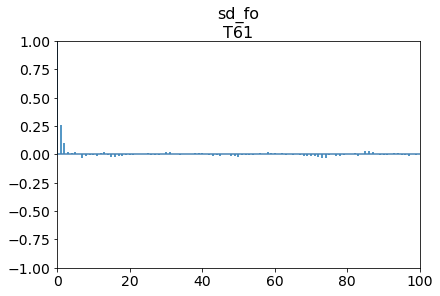

In [485]:
if critique:
    magnitude = 'sd_fo'
    with az.rc_context(rc={'plot.max_subplots': None}):
        az.plot_autocorr(my_model_trace, combined=True, var_names=[magnitude])
    plt.savefig(
        f'{reports_dir}critique/{model_name}_{method}_{nucleus}/autocorr_{magnitude}.png')

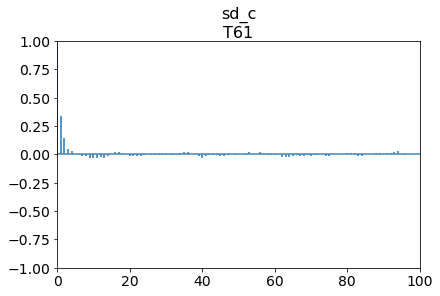

In [486]:
if critique:
    magnitude = 'sd_c'
    with az.rc_context(rc={'plot.max_subplots': None}):
        az.plot_autocorr(my_model_trace, combined=True, var_names=[magnitude])
    plt.savefig(
        f'{reports_dir}critique/{model_name}_{method}_{nucleus}/autocorr_{magnitude}.png')

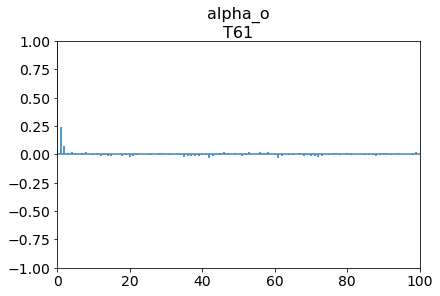

In [487]:
if critique:
    magnitude = 'alpha_o'
    with az.rc_context(rc={'plot.max_subplots': None}):
        az.plot_autocorr(my_model_trace, combined=True, var_names=[magnitude])
    plt.savefig(
        f'{reports_dir}critique/{model_name}_{method}_{nucleus}/autocorr_{magnitude}.png')

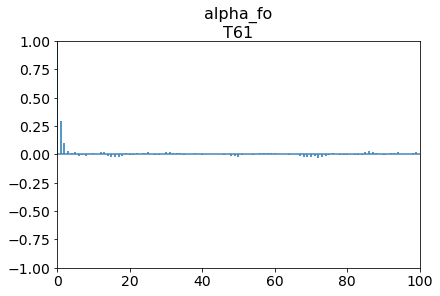

In [488]:
if critique:
    magnitude = 'alpha_fo'
    with az.rc_context(rc={'plot.max_subplots': None}):
        az.plot_autocorr(my_model_trace, combined=True, var_names=[magnitude])
    plt.savefig(
        f'{reports_dir}critique/{model_name}_{method}_{nucleus}/autocorr_{magnitude}.png')

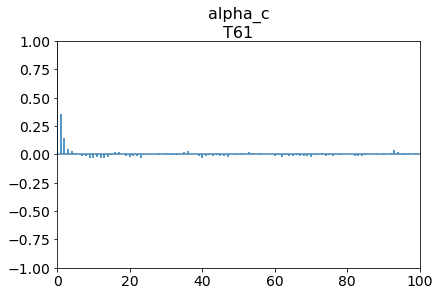

In [489]:
if critique:
    magnitude = 'alpha_c'
    with az.rc_context(rc={'plot.max_subplots': None}):
        az.plot_autocorr(my_model_trace, combined=True, var_names=[magnitude])
    plt.savefig(
        f'{reports_dir}critique/{model_name}_{method}_{nucleus}/autocorr_{magnitude}.png')

### Posterior Predictive Test

### PPC Closed

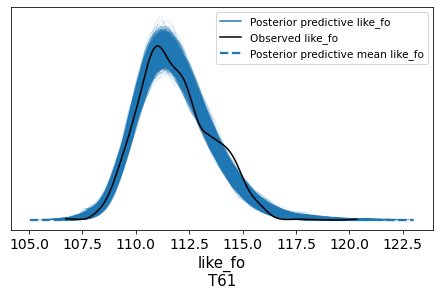

In [490]:
if do_ppc:
    state = 'fo'
    az.plot_ppc(my_model_trace, flatten=['step'], var_names = [f'like_{state}'], random_seed=RANDOM_SEED)
    plt.savefig(f'{reports_dir}critique/{model_name}_{method}_{nucleus}/ppc_{state}.png')

### PPC Fully Open

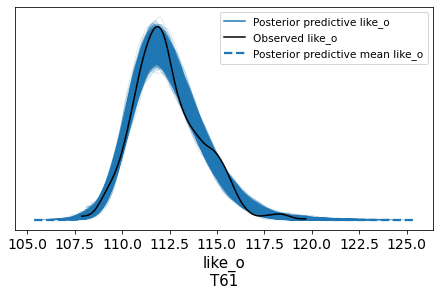

In [491]:
if do_ppc:
    state = 'o'
    az.plot_ppc(my_model_trace, flatten=['step'], var_names = [f'like_{state}'], random_seed=RANDOM_SEED)
    plt.savefig(f'{reports_dir}critique/{model_name}_{method}_{nucleus}/ppc_{state}.png')

### PPC Open

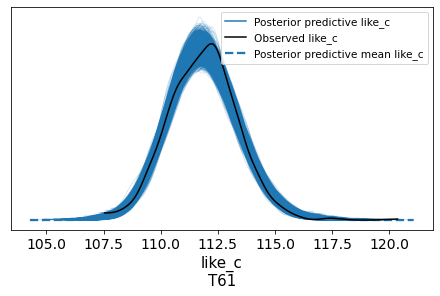

In [492]:
if do_ppc:
    state = 'c'
    az.plot_ppc(my_model_trace, flatten=['step'], var_names = [f'like_{state}'], random_seed=RANDOM_SEED)
    plt.savefig(f'{reports_dir}critique/{model_name}_{method}_{nucleus}/ppc_{state}.png')

## Investigate

In [493]:
my_model = az.from_netcdf(model_path)

In [494]:
my_model.posterior = combine_posterior_variables(
    my_model.posterior, ['mu_o', 'mu_fo', 'mu_c'], 'mu', 'state',
    ['o', 'fo', 'c'])

In [495]:
my_model.posterior = combine_posterior_variables(
    my_model.posterior, ['sd_o', 'sd_fo', 'sd_c'], 'sd', 'state',
    ['o', 'fo', 'c'])

In [496]:
my_model.posterior = combine_posterior_variables(
    my_model.posterior, ['alpha_o', 'alpha_fo', 'alpha_c'], 'alpha', 'state',
    ['o', 'fo', 'c'])

In [497]:
my_model.posterior = combine_posterior_variables(
    my_model.posterior, ['mean_o_c', 'mean_fo_c'], 'mean_ref', 'state',
    ['o', 'fo'])

In [498]:
my_model.posterior = combine_posterior_variables(
    my_model.posterior, ['mean_o', 'mean_fo', 'mean_c'], 'mean', 'state',
    ['o', 'fo', 'c'])

### Is it Skewed?

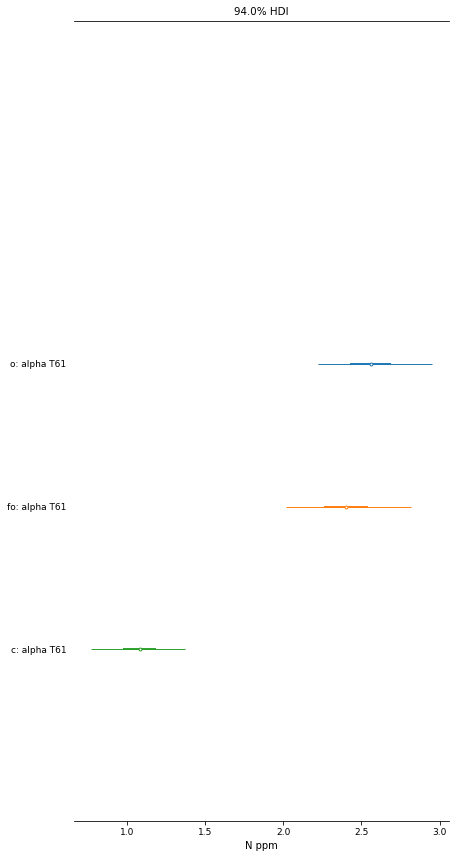

In [499]:
%%ding
variable = 'alpha'
az.plot_forest((my_model.sel(state="o"), 
                my_model.sel(state="fo"),
                my_model.sel(state="c")),
               var_names=variable,
               combined=True,
               colors=["C0", "C1","C2"],
               model_names=["o", "fo","c"],
               textsize=9,
               figsize=(7, 15))
plt.xlabel(f'{nucleus} ppm')
plt.savefig(f'{reports_dir}figures/{variable}_{model_name}_{method}_{nucleus}.png')
plt.tight_layout()

### Difference in CS

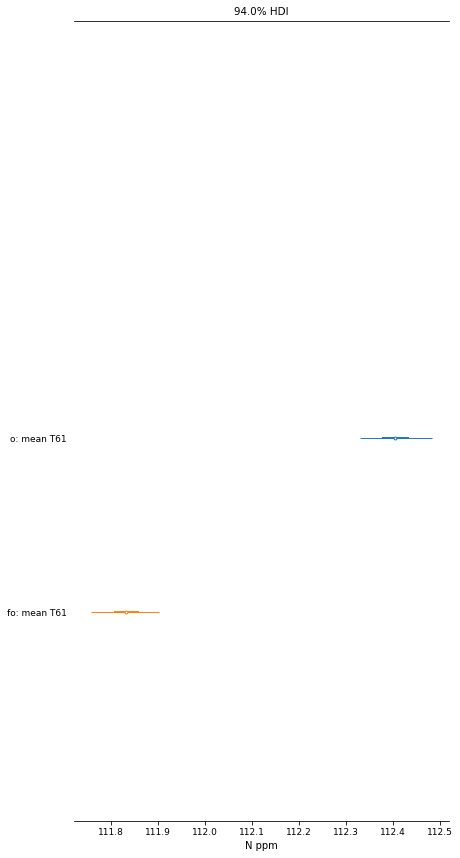

In [500]:
%%ding
az.plot_forest(
    (my_model.sel(state="o"), my_model.sel(state="fo")),
    var_names="mean",
    combined=True,
    colors=["C0", "C1"],
    model_names=["o", "fo"],
    textsize=9,
    figsize=(7, 15),
)
plt.xlabel(f'{nucleus} ppm')
plt.savefig(f'{reports_dir}figures/mu_{model_name}_{method}_{nucleus}.png')
plt.tight_layout()

### Which signals are statistically different in o/fo

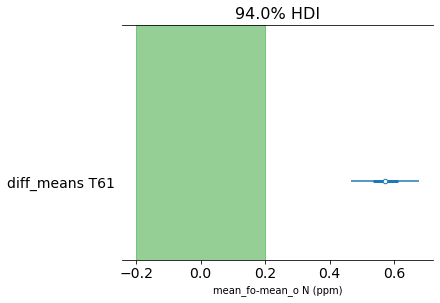

In [501]:
az.plot_forest(my_model.posterior, rope=(-0.2, 0.2), combined=True,
              var_names=['diff_means'])
plt.xlabel(f'mean_fo-mean_o {nucleus} (ppm)')
plt.savefig(f'{reports_dir}figures/diff_mu_{model_name}_{method}_{nucleus}.png')

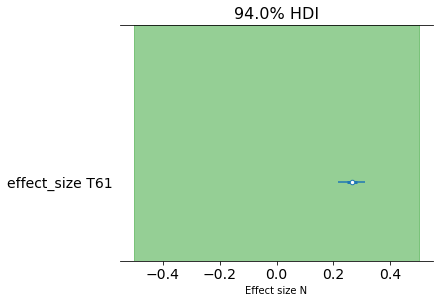

In [502]:
az.plot_forest(my_model, combined=True, var_names=['effect_size'], rope=(-0.5, 0.5))
plt.xlabel(f'Effect size {nucleus}')
plt.savefig(f'{reports_dir}figures/effect_size_{model_name}_{method}_{nucleus}.png')

### Assignment

CA

sparta_plus

In [63]:
studied_res = get_significant( models_dir + f"{model_name}_sparta_plus_CA.nc")
studied_res

['A50',
 'Q58',
 'T61',
 'R64',
 'T75',
 'Y78',
 'R89',
 'V93',
 'M96',
 'A98',
 'S102',
 'T107']

ppm

In [64]:
studied_res = get_significant( models_dir + f"{model_name}_ppm_CA.nc")
studied_res

['Y62', 'R64', 'Y78', 'V93', 'G99', 'S102', 'T107']

shiftx2

In [65]:
studied_res = [ 'G56', 'T61', 'M96', 'G99', 'T107' ]

In [66]:
print(get_significant( models_dir + f"{model_name}_shiftx2_CA.nc"))

['T61', 'R64', 'Y78', 'R89', 'M96', 'G99', 'S102', 'T107']


N

In [67]:
studied_res = get_significant( models_dir + f"{model_name}_sparta_plus_N.nc")
studied_res

['L59',
 'T61',
 'V93',
 'M96',
 'V97',
 'A98',
 'G99',
 'S102',
 'F103',
 'T107',
 'L110']

sparta_plus

ppm

In [68]:
studied_res = get_significant( models_dir + f"{model_name}_ppm_N.nc")
studied_res

['P55',
 'L59',
 'I60',
 'T72',
 'Y78',
 'M96',
 'V97',
 'A98',
 'S102',
 'F103',
 'T107',
 'A108',
 'A111']

shiftx2

C

sparta_plus

In [69]:
studied_res = get_significant( models_dir + f"{model_name}_sparta_plus_C.nc")
studied_res

['A50', 'E51', 'G56', 'Q58', 'L59', 'M96', 'V97', 'G99']

ppm

In [70]:
studied_res = get_significant( models_dir + f"{model_name}_ppm_C.nc")
studied_res

['A50', 'E51', 'Y62', 'S69', 'Y78', 'A92', 'M96', 'G99', 'T107']

shiftx2

In [71]:
studied_res = [ 'A50' ]

In [72]:
print(get_significant( models_dir + f"{model_name}_shiftx2_C.nc"))

['A50', 'M96', 'G99', 'A108', 'T112']


CB

sparta_plus

In [73]:
studied_res = get_significant( models_dir + f"{model_name}_sparta_plus_CB.nc")
studied_res

['I60', 'T61', 'Y62', 'M96', 'V97', 'T107']

ppm

In [74]:
studied_res = get_significant( models_dir + f"{model_name}_ppm_CB.nc")
studied_res

['E51', 'T61', 'Y62', 'T74', 'Y78', 'V94', 'V95', 'M96', 'A98', 'S102']

shiftx2

In [75]:
studied_res = [ 'I60', 'T61', 'Y78', 'M96', 'A98', 'S102' ]

In [76]:
print(get_significant( models_dir + f"{model_name}_shiftx2_CB.nc"))

['I60', 'T61', 'R64', 'Y78', 'M96', 'A98', 'S102']


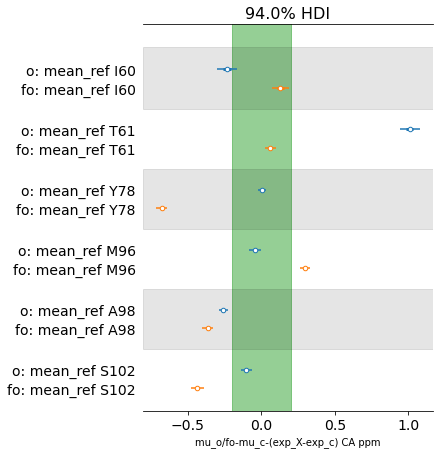

In [77]:
az.plot_forest(
    (my_model.posterior.sel(state="o"), my_model.posterior.sel(state="fo")),
    var_names="mean_ref",
    combined=True,
    colors=["C0", "C1"],
    model_names=["o", "fo"],
    rope=(-0.2, 0.2),
    coords={'resid': studied_res}
)
plt.xlabel(f'mu_o/fo-mu_c-(exp_X-exp_c) {nucleus} ppm')
plt.savefig(f'{reports_dir}figures/assignment_{model_name}_{method}_{nucleus}.png')

All

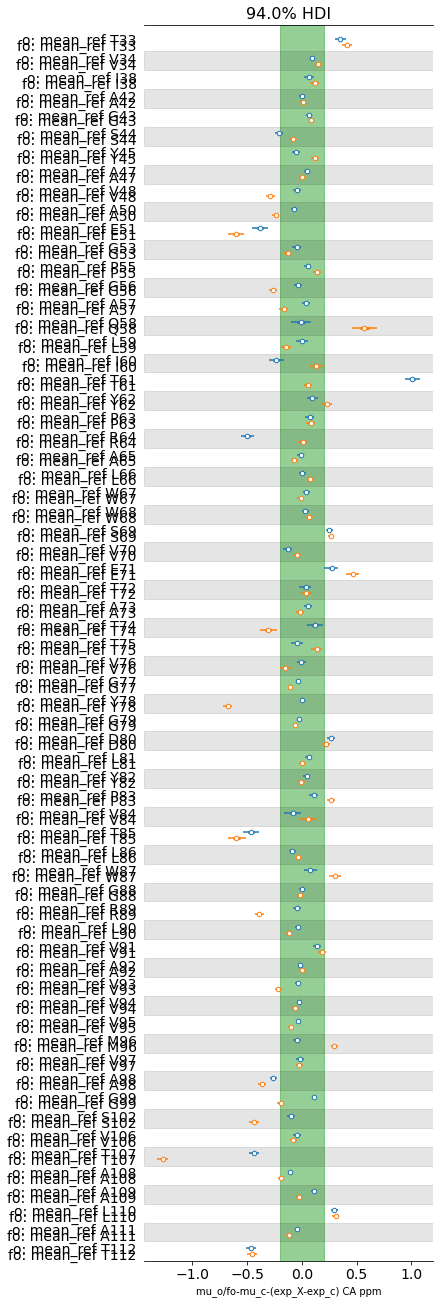

In [78]:
az.plot_forest(
    (my_model.posterior.sel(state="o"), my_model.posterior.sel(state="fo")),
    var_names="mean_ref",
    combined=True,
    colors=["C0", "C1"],
    model_names=["o", "fo"],
    rope=(-0.2, 0.2),
    #coords={'resid': studied_res}
)
plt.xlabel(f'mu_o/fo-mu_c-(exp_X-exp_c) {nucleus} ppm')
plt.savefig(f'{reports_dir}figures/assignment_all_{model_name}_{method}_{nucleus}.png')

## Print Quality Figures

In [79]:
my_model = az.from_netcdf(model_path)

In [80]:
my_model.posterior = combine_posterior_variables(
    my_model.posterior, ['mu_o', 'mu_fo', 'mu_c'], 'mu', 'state',
    ['o', 'fo', 'c'])

In [81]:
my_model.posterior = combine_posterior_variables(
    my_model.posterior, ['sd_o', 'sd_fo', 'sd_c'], 'sd', 'state',
    ['o', 'fo', 'c'])

In [82]:
my_model.posterior = combine_posterior_variables(
    my_model.posterior, ['mu_o_c', 'mu_fo_c'], r'$\Delta$CS$_{theo}$', 'state',
    ['o', 'fo'])

KeyError: 'mu_o_c'

In [ ]:
az.plot_forest(
    (my_model.posterior.sel(state="o"), my_model.posterior.sel(state="fo")),
    var_names="$\Delta$CS$_{theo}$",
    combined=True,
    colors=["C0", "C1"],
    model_names=["o", "fo"],
    rope=(-0.2, 0.2),
    coords={'resid': studied_res}
)
plt.xlabel(r'$\Delta$CS$_{theo}$-$\Delta$CS$_{exp}$  (ppm)',size=15)
plt.title(r'C$_\alpha$ Chemical Shifts', size=20)
plt.xlim([-1.3,1])
